In [1]:
import argparse
import subprocess
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import concurrent.futures
from matplotlib.patches import Patch

def load_data(input_dir):

    def stats_type_from_file_name(file_name):
        return file_name.split("_")[-1].split(".")[0]
    records = []
    for f in os.listdir(input_dir):
        if f.endswith(".json"):
            with open(os.path.join(input_dir, f)) as json_f:
                records.extend(json.load(json_f)[1:])
    df = pd.DataFrame(records)
    df['time_per_column'] = df['metadata_end_to_end_load_time_nanos'] / df['column_cnt']
    df['stats'] = df.apply(lambda x: stats_type_from_file_name(x['file_name']), axis=1)
    return df

In [45]:
input_dir =  "../target/wide_table_bench"

df = load_data(input_dir) 

df['size_per_column'] = df['metadata_len'] / df['column_cnt']
df['bytes_per_ms'] = df['metadata_len'] / (df['metadata_end_to_end_load_time_nanos'] / 1_000_000)

def stats_order(x):
	if x['stats'] == 'none':
		return 1
	if x['stats'] == 'chunk':
		return 2
	if x['stats'] == 'page':
		return 3
df['order'] = df.apply(stats_order, axis=1)
df.sort_values(by='order', inplace=True)

In [39]:
df

,metadata_end_to_end_load_time_nanos,schema_build_time_nanos,thrift_decode_time_nanos,file_open_time_nanos,metadata_len,column_cnt,row_group_cnt,row_cnt,file_name,time_per_column,stats,size_per_column,order
8,10109990,632806,9472065,5119,1346302,2000,10,5000000,2000col_10b_none.parquet,5054.99500,none,673.15100,1
9,8757928,647674,8107318,2936,1346302,2000,10,5000000,2000col_10b_none.parquet,4378.96400,none,673.15100,1
10,8738682,637335,8098763,2584,1346302,2000,10,5000000,2000col_10b_none.parquet,4369.34100,none,673.15100,1
11,8596257,635571,7958252,2434,1346302,2000,10,5000000,2000col_10b_none.parquet,4298.12850,none,673.15100,1
80,293548888,17649996,275892901,5991,34128324,50000,10,200000,50000col_10b_none.parquet,5870.97776,none,682.56648,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,13888403,642584,13243465,2354,2387631,2000,10,5000000,2000col_10b_page.parquet,6944.20150,page,1193.81550,3
99,14504809,642814,13858178,3817,2387631,2000,10,5000000,2000col_10b_page.parquet,7252.40450,page,1193.81550,3
1,774248,36297,735677,2274,123120,100,10,100000000,100col_10b_page.parquet,7742.48000,page,1231.20000,3
2,765233,35136,728013,2084,123120,100,10,100000000,100col_10b_page.parquet,7652.33000,page,1231.20000,3


In [40]:
time_per_column = df.groupby('stats')[['time_per_column', 'stats']].describe()['time_per_column']
time_per_column.sort_values(by='mean', ascending=True, inplace=True)

size_per_column = df.groupby('stats')[['size_per_column', 'stats']].describe()['size_per_column']
size_per_column.sort_values(by='mean', ascending=True, inplace=True)

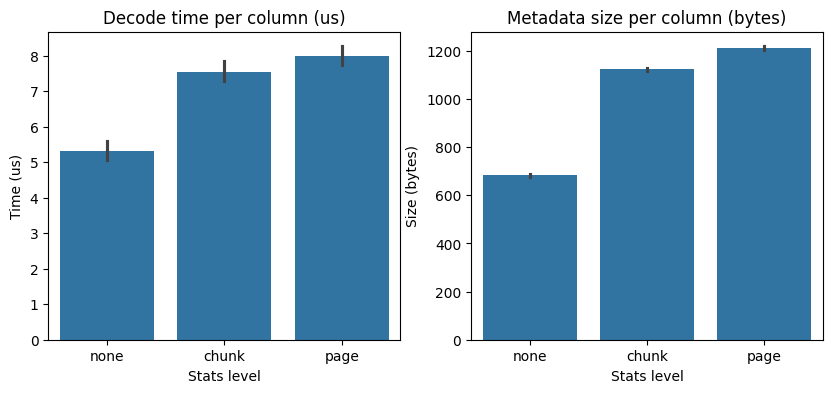

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x='stats', y='time_per_column', data=df, ax=ax1)
ax1.set_xlabel('Stats level')
ax1.set_ylabel('Time (us)')
ax1.set_title('Decode time per column (us)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x/1e3)))

sns.barplot(x='stats', y='size_per_column', data=df, ax=ax2)
ax2.set_xlabel('Stats level')
ax2.set_ylabel('Size (bytes)')
ax2.set_title('Metadata size per column (bytes)')
fig.savefig('per_column_overhead.png', dpi=300)


<Axes: xlabel='stats', ylabel='bytes_per_ms'>

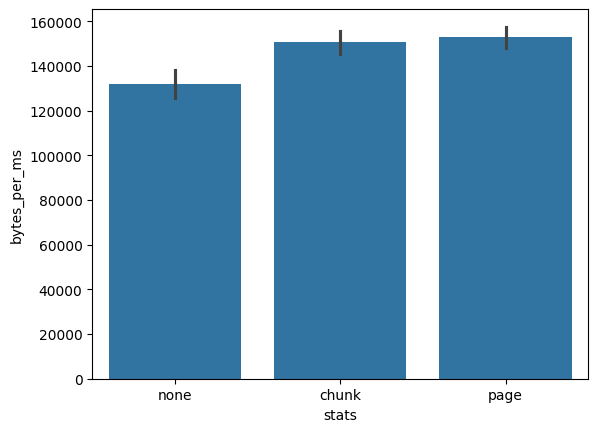

In [46]:
sns.barplot(x='stats', y='bytes_per_ms', data=df)